<a href="https://colab.research.google.com/github/keran-w/3d-deep-learning/blob/main/Notebooks/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This time, we directly load data from pickle file

# Imports

In [ ]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from tqdm import tqdm
from google.colab import drive
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pandas_profiling import ProfileReport
from matplotlib.animation import FuncAnimation

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

# import lightning.pytorch as pl

import warnings
warnings.filterwarnings('ignore')

# Setup

In [ ]:
drive.mount('/content/drive', force_remount=True)

dataset_name = 'modelnet40'
%cd /content/drive/MyDrive/dataset/{dataset_name}
base_path = Path('.')
clear_output()

# Dataset

In [ ]:
X_train, y_train = pickle.load(open('saved_data/train_dataset.pkl','rb'))
X_test, y_test = pickle.load(open('saved_data/test_dataset.pkl','rb'))

In [ ]:
le = LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)
y_test_ = le.transform(y_test)

In [ ]:
label_map = dict(zip(le.transform(le.classes_), le.classes_))
num_labels = len(label_map)
label_map

{0: 'airplane',
 1: 'bed',
 2: 'bench',
 3: 'bookshelf',
 4: 'bottle',
 5: 'bowl',
 6: 'car',
 7: 'chair',
 8: 'cone',
 9: 'cup',
 10: 'curtain',
 11: 'door',
 12: 'guitar',
 13: 'keyboard',
 14: 'lamp',
 15: 'laptop',
 16: 'mantel',
 17: 'person',
 18: 'piano',
 19: 'plant',
 20: 'radio',
 21: 'sink',
 22: 'stairs',
 23: 'stool',
 24: 'tent',
 25: 'toilet',
 26: 'vase',
 27: 'wardrobe',
 28: 'xbox'}

In [ ]:
class bitmapDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index]).float(), self.y[index]

train_dataset = bitmapDataset(X_train, y_train_)
test_dataset = bitmapDataset(X_test, y_test_)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
sample_batch = next(iter(train_loader))
sample_X, sample_y = sample_batch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class MVNet(nn.Module):
    def __init__(self, num_labels):
        super(MVNet, self).__init__()
        self.conv1 = nn.LazyConv2d(out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.LazyConv2d(out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(num_labels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

sample_model = MVNet(num_labels).to(device)
sample_output = sample_model(sample_X.float().to(device))

In [ ]:
sample_criterion = nn.CrossEntropyLoss()
sample_optimizer = optimizer = torch.optim.Adam(sample_model.parameters(), lr=1e-3)
sample_loss = sample_criterion(sample_output, sample_y.to(device))
sample_loss

tensor(3.3799, device='cuda:0', grad_fn=<NllLossBackward0>)

# Train

In [ ]:
model = MVNet(num_labels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 10

for epoch in range(n_epoch):
    model.train()
    train_pbar = tqdm(train_loader)
    train_pbar.set_description_str(f'[ Train {epoch+1:03d}/{n_epoch:03d} ]')
    loss_list, acc_list = [], []
    for batch in train_pbar:
        X, y = batch
        # loss = train_step(model, optimizer, criterion, batch, device)
        optimizer.zero_grad()
        logits = model(X.float().to(device))
        true_labels = y.long().to(device)
        loss = criterion(logits, true_labels)
        loss.backward()
        optimizer.step()
        train_pbar.set_postfix_str(f'loss: {loss}')
        loss_list.append(loss.item())
        
    model.eval()
    with torch.no_grad():
        test_pbar = tqdm(test_loader)
        test_pbar.set_description_str(f'[ Test {epoch+1:03d}/{n_epoch:03d} ]')
        for batch in test_pbar:
            X, y = batch
            logits = model(X.float().to(device)).detach()
            true_labels = y.long().to(device)

            results = {}
            metric = 'acc'
            results[metric] = (logits.argmax(1) == true_labels).float().mean().item()
            test_pbar.set_postfix_str(f'{" ".join([f"{k}: {v}" for k, v in results.items()])}')
            acc_list.append(results['acc'])

    print(f'Average train loss: {np.mean(loss_list):.4f} Average test accuracy: {np.mean(acc_list):.3f}')

[ Test 001/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.51it/s, acc: 0.1587301641702652]


Average train loss: 2.6109 Average test accuracy: 0.541


[ Test 002/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.56it/s, acc: 0.3968254327774048]


Average train loss: 1.6810 Average test accuracy: 0.612


[ Test 003/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.53it/s, acc: 0.4603174924850464]


Average train loss: 1.3559 Average test accuracy: 0.658


[ Test 004/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.52it/s, acc: 0.4285714626312256]


Average train loss: 1.1226 Average test accuracy: 0.672


[ Test 005/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.53it/s, acc: 0.4285714626312256]


Average train loss: 0.9500 Average test accuracy: 0.696


[ Test 006/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.55it/s, acc: 0.4761905074119568]


Average train loss: 0.8059 Average test accuracy: 0.705


[ Test 007/010 ]: 100%|██████████| 24/24 [00:10<00:00,  2.31it/s, acc: 0.4126984477043152]


Average train loss: 0.6685 Average test accuracy: 0.704


[ Test 008/010 ]: 100%|██████████| 24/24 [00:10<00:00,  2.37it/s, acc: 0.444444477558136]


Average train loss: 0.5865 Average test accuracy: 0.699


[ Test 009/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.53it/s, acc: 0.4285714626312256]


Average train loss: 0.5055 Average test accuracy: 0.691


[ Test 010/010 ]: 100%|██████████| 24/24 [00:09<00:00,  2.55it/s, acc: 0.4126984477043152]

Average train loss: 0.4203 Average test accuracy: 0.692


In [ ]:
model.eval()
pred_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        X, y = batch
        logits = model(X.float().to(device)).detach()
        pred_labels += logits.argmax(1).tolist()


100%|██████████| 24/24 [00:09<00:00,  2.53it/s]


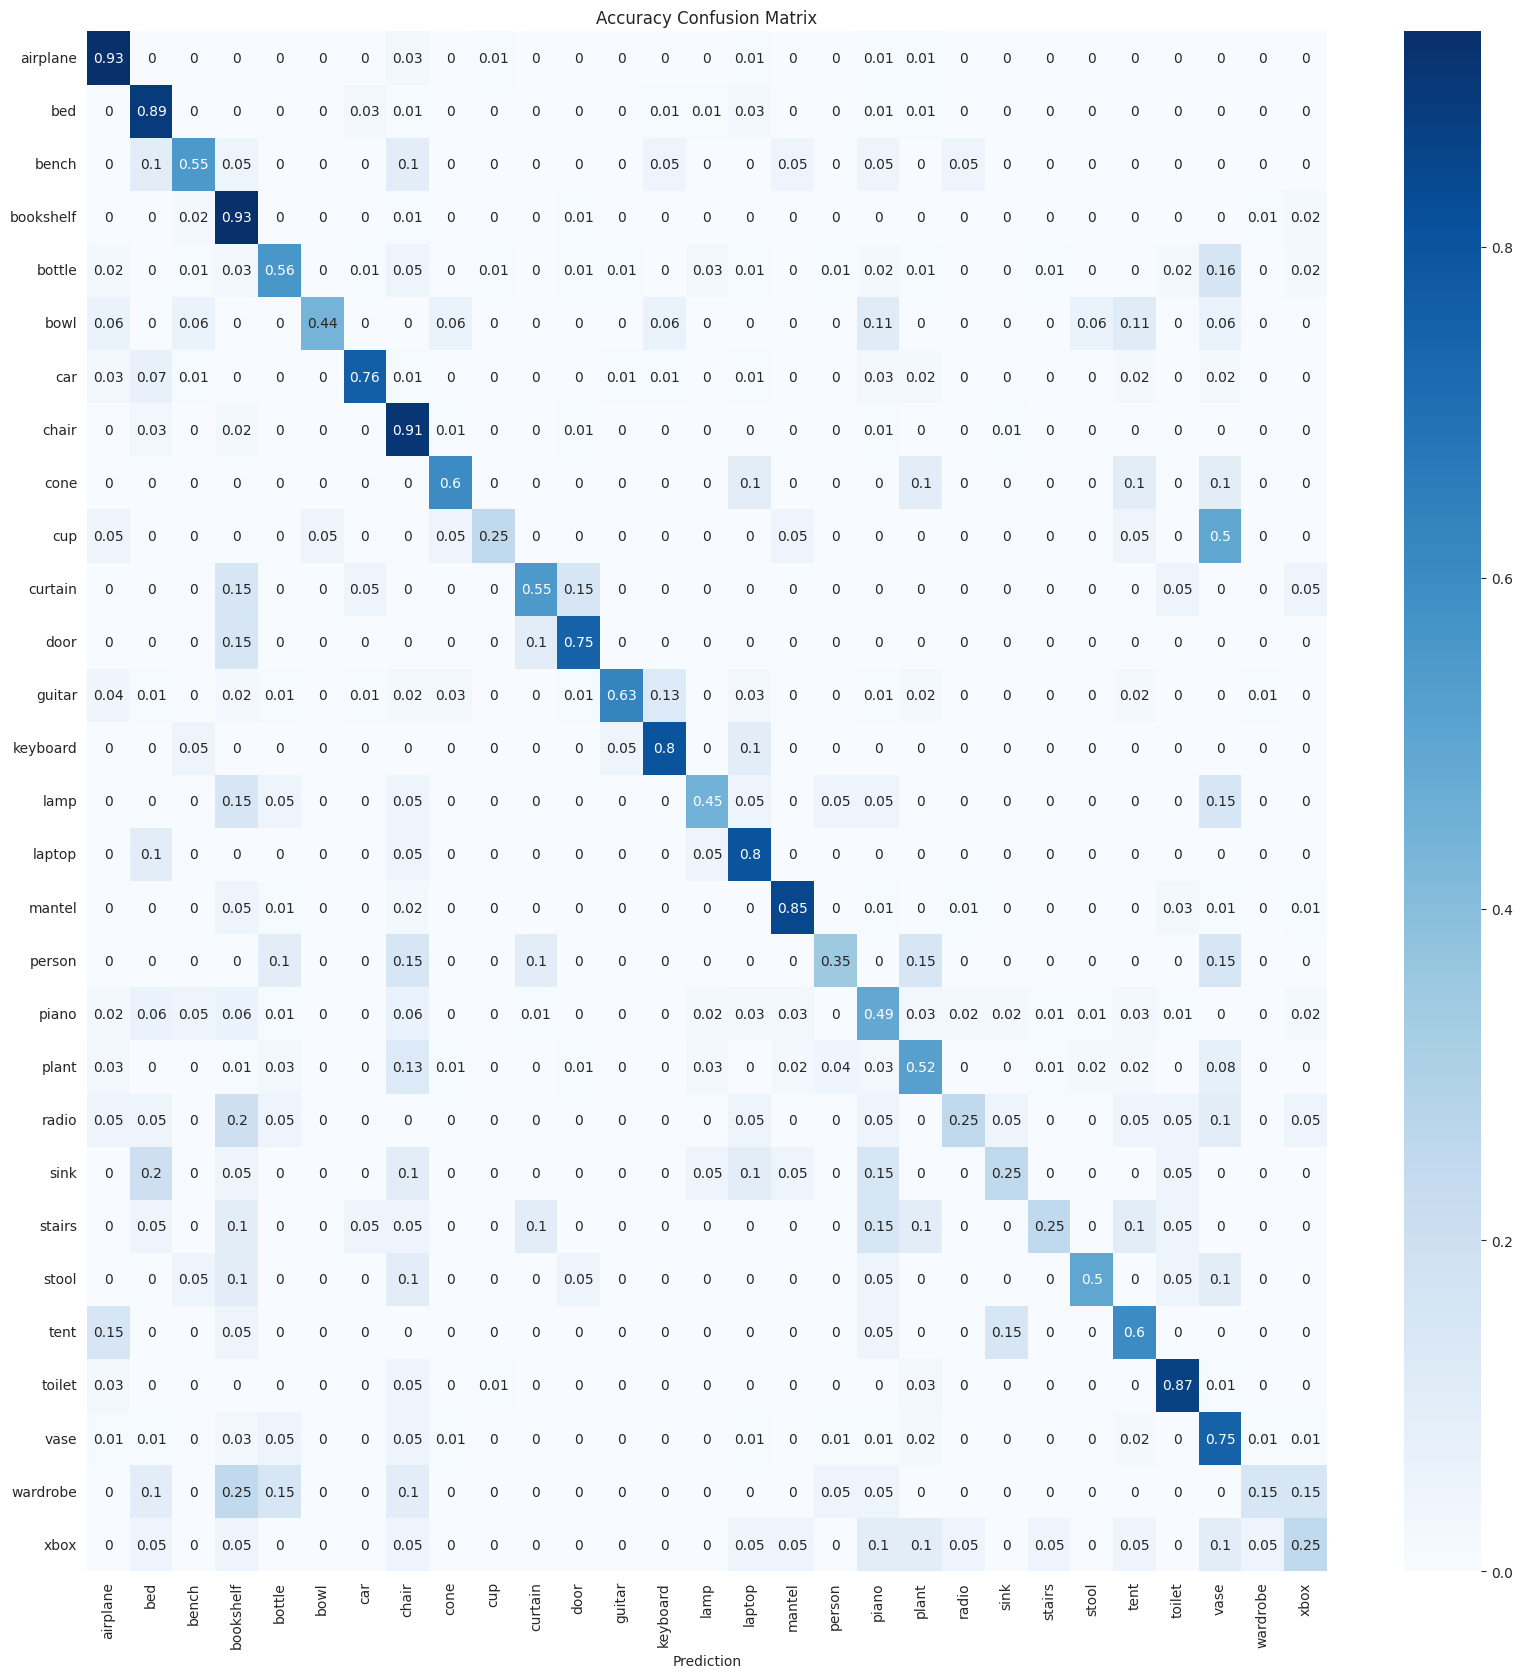

In [ ]:
import seaborn as sns
from sklearn import metrics
cf_matrix = metrics.confusion_matrix(y_test_, pred_labels)
cf_matrix = pd.DataFrame(cf_matrix, columns=list(label_map.values()), index=list(label_map.values()))
cf_matrix = np.round(cf_matrix / cf_matrix.sum(1).values.repeat(num_labels).reshape(num_labels, num_labels), 2)
plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True, cmap="Blues")
# plt.title('Prediction Confusion Matrix')
plt.title('Accuracy Confusion Matrix')
plt.xlabel('True label')
plt.xlabel('Prediction')
plt.show()